
Data Loading Status:
Loaded results/CMARL_seed_42/final_results.csv with 200 rows
Loaded results/CMARL_seed_43/final_results.csv with 200 rows
Loaded results/CMARL_seed_44/final_results.csv with 200 rows
CMARL data summary:
          episode  success   collision
count  600.000000  600.000  600.000000
mean    99.500000    0.260    0.136667
std     57.782477    0.439    0.343782
min      0.000000    0.000    0.000000
25%     49.750000    0.000    0.000000
50%     99.500000    0.000    0.000000
75%    149.250000    1.000    0.000000
max    199.000000    1.000    1.000000
Loaded results/MARL_seed_42/final_results.csv with 200 rows
Loaded results/MARL_seed_43/final_results.csv with 200 rows
Loaded results/MARL_seed_44/final_results.csv with 200 rows
MARL data summary:
          episode     success   collision
count  600.000000  600.000000  600.000000
mean    99.500000    0.078333    0.201667
std     57.782477    0.268920    0.401579
min      0.000000    0.000000    0.000000
25%     49.7500

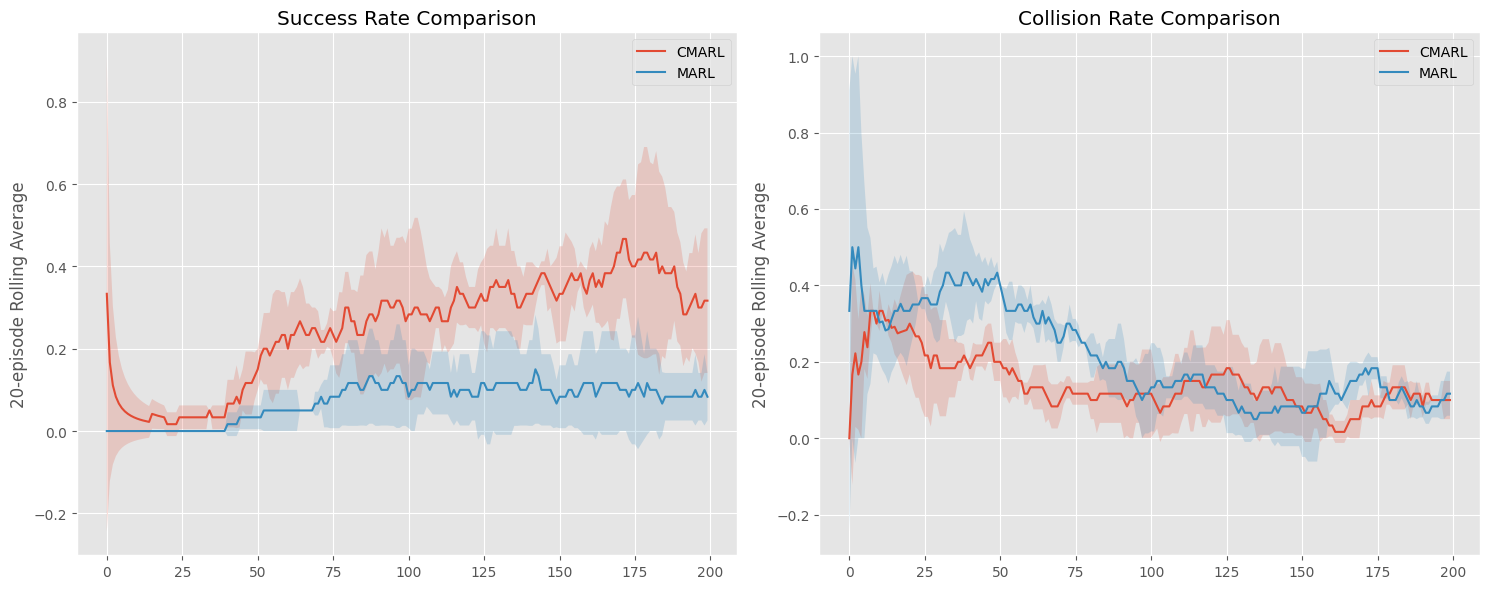

Adjusted episode threshold to 99


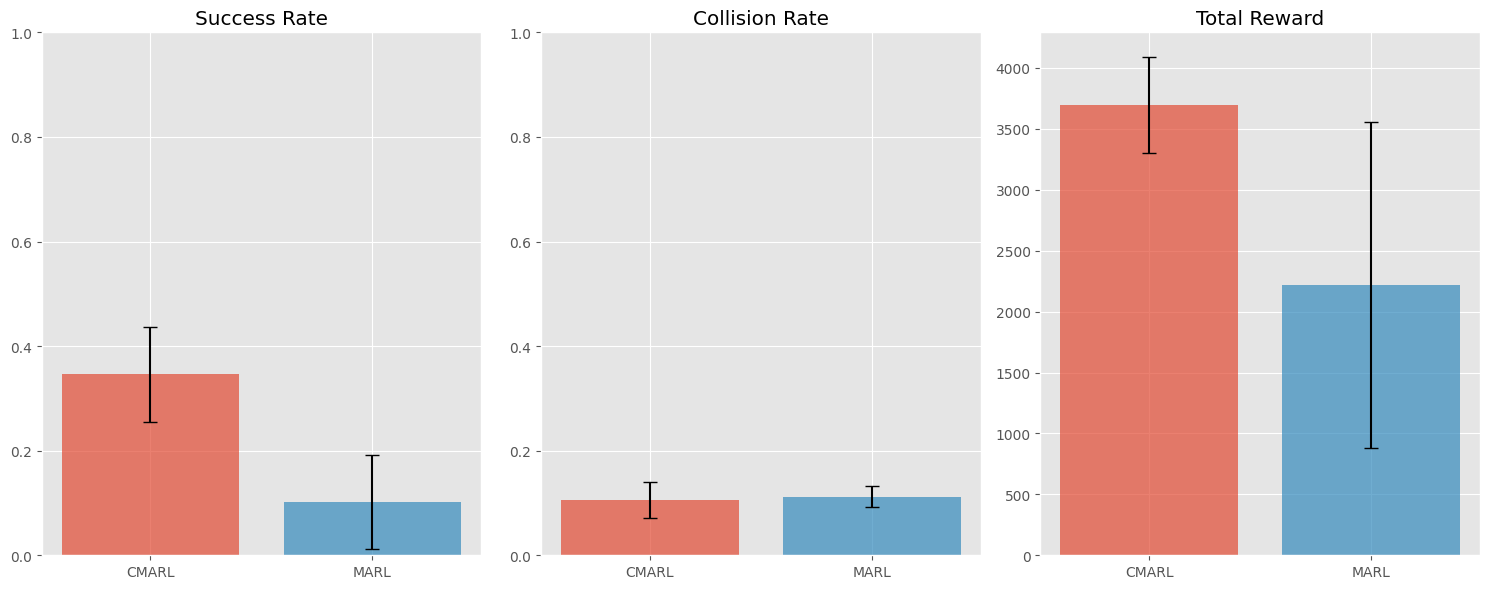

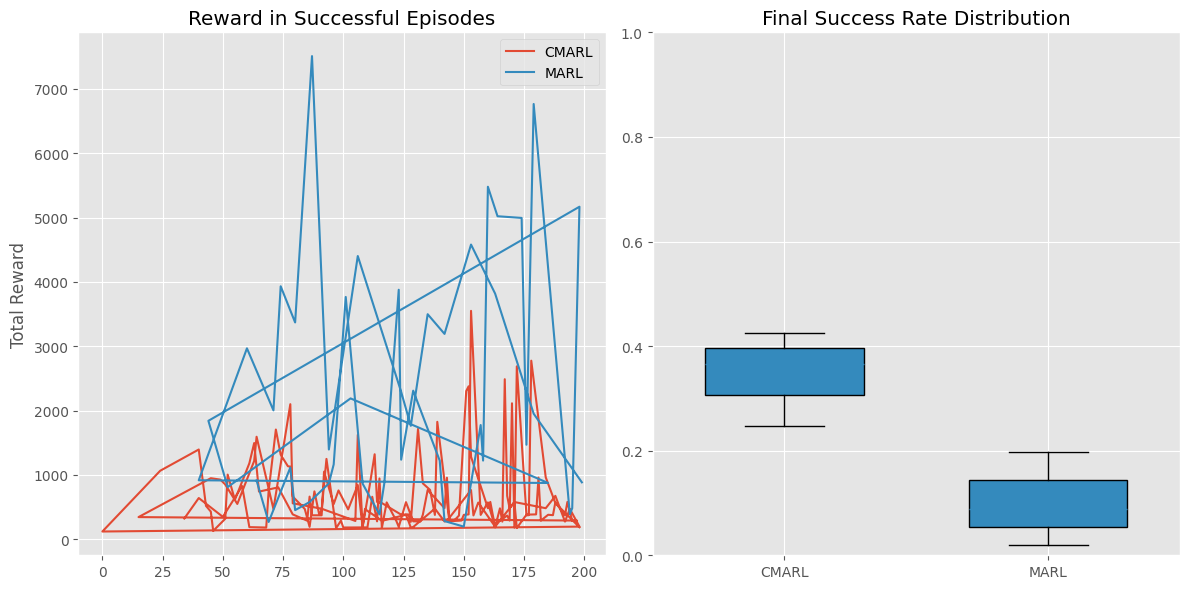

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

# Data loading with validation
def load_results(algorithm, seeds):
    dfs = []
    for seed in seeds:
        path = f"results/{algorithm}_seed_{seed}/final_results.csv"
        if os.path.exists(path):
            try:
                df = pd.read_csv(path)
                if not df.empty:
                    print(f"Loaded {path} with {len(df)} rows")
                    df['algorithm'] = algorithm
                    df['seed'] = seed
                    dfs.append(df)
                else:
                    print(f"Empty file: {path}")
            except Exception as e:
                print(f"Error loading {path}: {str(e)}")
        else:
            print(f"Missing file: {path}")
    return pd.concat(dfs) if dfs else pd.DataFrame()

# Load all data with verification
seeds = [42, 43, 44]
algorithms = ['CMARL', 'MARL']

# Check data loading
print("\nData Loading Status:")
data_frames = []
for algo in algorithms:
    df = load_results(algo, seeds)
    if not df.empty:
        print(f"{algo} data summary:")
        print(df[['episode', 'success', 'collision']].describe())
        data_frames.append(df)
    else:
        print(f"No data loaded for {algo}")

if not data_frames:
    raise ValueError("No data available for visualization")

combined_df = pd.concat(data_frames)

# Calculate rolling averages with buffer check
window_size = 20
if len(combined_df) < window_size:
    print(f"Not enough data ({len(combined_df)} rows) for window size {window_size}")
    window_size = min(5, len(combined_df))  # Reduce window size

combined_df['rolling_success'] = combined_df.groupby(['algorithm', 'seed'])['success'].transform(
    lambda x: x.rolling(window_size, min_periods=1).mean()
)
combined_df['rolling_collision'] = combined_df.groupby(['algorithm', 'seed'])['collision'].transform(
    lambda x: x.rolling(window_size, min_periods=1).mean()
)

# Training progress visualization with data checks
def plot_with_validation(data, y_col, title, ylabel, ax):
    if data.empty:
        ax.text(0.5, 0.5, 'No data available', 
                ha='center', va='center', fontsize=12)
        ax.set_title(title)
        return
    
    for algo in algorithms:
        algo_data = data[data['algorithm'] == algo]
        if not algo_data.empty:
            episodes = algo_data['episode'].unique()
            means = [algo_data[algo_data['episode'] == ep][y_col].mean() for ep in episodes]
            stds = [algo_data[algo_data['episode'] == ep][y_col].std() for ep in episodes]
            
            ax.plot(episodes, means, label=algo)
            ax.fill_between(episodes, 
                           np.array(means)-np.array(stds), 
                           np.array(means)+np.array(stds), 
                           alpha=0.2)
        else:
            print(f"⚠️ No data for {algo} in {title}")
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_with_validation(combined_df, 'rolling_success', 
                    'Success Rate Comparison', 
                    '20-episode Rolling Average', ax1)
plot_with_validation(combined_df, 'rolling_collision', 
                    'Collision Rate Comparison', 
                    '20-episode Rolling Average', ax2)
plt.tight_layout()
plt.show()

# Final performance comparison with episode validation
episode_threshold = 250
if combined_df['episode'].max() < episode_threshold:
    episode_threshold = combined_df['episode'].max() // 2
    print(f"Adjusted episode threshold to {episode_threshold}")

final_perf = combined_df[combined_df['episode'] >= episode_threshold].groupby(
    ['algorithm', 'seed']).agg({
        'success': 'mean',
        'collision': 'mean',
        'total_reward': 'mean'
    }).reset_index()

# Visualization with fallback
if not final_perf.empty:
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    metrics = ['success', 'collision', 'total_reward']
    titles = ['Success Rate', 'Collision Rate', 'Total Reward']
    
    for ax, metric, title in zip(axes, metrics, titles):
        ax.set_title(title)
        if metric in ['success', 'collision']:
            ax.set_ylim(0, 1)
        
        for i, algo in enumerate(algorithms):
            algo_data = final_perf[final_perf['algorithm'] == algo]
            if not algo_data.empty:
                mean_val = algo_data[metric].mean()
                std_val = algo_data[metric].std()
                ax.bar(i, mean_val, yerr=std_val, 
                       capsize=5, alpha=0.7, label=algo)
        
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels(algorithms)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data for final performance comparison")

# Advanced analysis with data checks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Successful episodes analysis
success_data = combined_df[combined_df['success'] == 1]
if not success_data.empty:
    for algo in algorithms:
        algo_data = success_data[success_data['algorithm'] == algo]
        if not algo_data.empty:
            ax1.plot(algo_data['episode'], algo_data['total_reward'], label=algo)
    ax1.set_title('Reward in Successful Episodes')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'No successful episodes', 
            ha='center', va='center', fontsize=12)
    ax1.set_title('Reward in Successful Episodes')

# Success rate distribution
if not final_perf.empty:
    for i, algo in enumerate(algorithms):
        data = final_perf[final_perf['algorithm'] == algo]['success']
        ax2.boxplot(data, positions=[i], widths=0.6, patch_artist=True)
    ax2.set_xticks(range(len(algorithms)))
    ax2.set_xticklabels(algorithms)
    ax2.set_title('Final Success Rate Distribution')
    ax2.set_ylim(0, 1)
else:
    ax2.text(0.5, 0.5, 'No final performance data', 
            ha='center', va='center', fontsize=12)
    ax2.set_title('Final Success Rate Distribution')

plt.tight_layout()
plt.show()